### **Nano Project 3**
In this project the objective is to solve the optimization problem:
$$\begin{align}\min_{\theta\in \mathbb{R}}\mathbb{E}\left(e^{-\theta^2}\phi^2(z+\theta)e^{-2\theta z}\right)\end{align}$$
Where $\phi$ is the option payoff with an underlying described by the Black Scholes framework.
This problem arises from variance reduction in parametric importance sampling when considering the Cameron Martin formular.
We first sketch out the problem framework:

Recall a European call option in the Black Scholes model:
The payoff of a European call option at expiration is given by:
$$
\varphi(S_T) = \max(S_T - K, 0)
$$
where:
- $ S_T $ is the stock price at expiration,
- $ K $ is the strike price,
- $ Z $ ia a standard gaussian r.v.

The simulated stock price at expiration is:
$
S_T = S_0 e^{(r - \frac{1}{2} \sigma^2)T + \sigma \sqrt{T} Z}
$

The **Cameron-Martin theorem** allows us to compute expectations under a shifted Gaussian measure.

Let $ Z \sim \mathcal{N}(0,1) $ be a standard normal variable with density:

$$
g_0(z) = \frac{e^{-z^2 / 2}}{\sqrt{2\pi}}.
$$

For a shift parameter $ \theta \in \Theta := \mathbb{R} $, we introduce the translated variable:

$$
Y_{\theta} = Z + \theta.
$$

The corresponding probability density function is:

$$
g_{\theta}(y) = \frac{e^{-(y - \theta)^2 / 2}}{\sqrt{2\pi}}.
$$

Using a **Radon-Nikodym derivative**, the ratio of densities under the translated and original measure is:

$$
\frac{g_{\theta}(y)}{g_0(y)} = e^{-\theta y + \theta^2 / 2}.
$$

Applying this density transformation to an expectation, we obtain:

$$
\mathbb{E}[\varphi(Z)]
= e^{-\theta^2 / 2} \mathbb{E} \left[ \varphi(Z + \theta)e^{-\theta(Z+\theta)} \right]
= e^{-\theta^2 / 2} \mathbb{E} \left[ \varphi(Z + \theta)e^{-\theta Z} \right].
$$
Which leads to the optimization problem (cf. Numerical probability page 189):
$$\min_{\theta\in \mathbb{R}}\mathbb{E}\left(e^{-\theta^2}\phi^2(z+\theta)e^{-2\theta z}\right)$$
We wish to find a $\theta$ that minimizes the variance which yields the problem (1) (cf. Numerical Probability p. 90-91)
To solve the minimization problem we use a stochastic gradient descent (SGD) algorithm.
We know from numerical probability p. 189 that the problem is stricly convex with $\mathbb{P}(\phi(Z)>0)>0$ and $\lim_{|\theta|\to+\infty}=+\infty$. By consequence there exists a unique global minimum in $\theta^*$ satisfying $\Delta_\theta\mathbb{E}\left(e^{-\theta^2}\phi^2(z+\theta)e^{-2\theta z}\right)=0 $. We first consider an out of the money call option and plot the function
$$\theta\mapsto \mathbb{E}\left(e^{-\theta^2}\phi^2(z+\theta)e^{-2\theta z}\right) $$

In [87]:
import numpy as np
import matplotlib.pyplot as plt

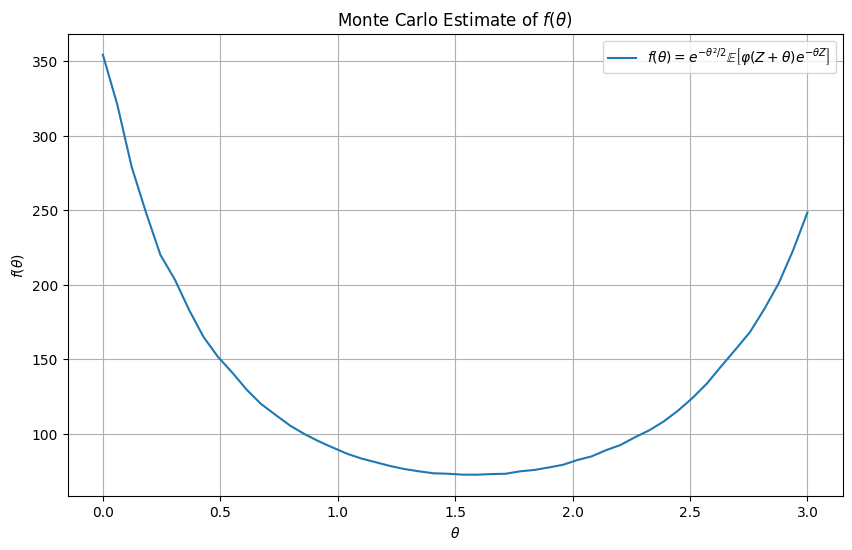

In [104]:

#setting parameters
S0 = 100.0  
K = 120   
T = 1.0      
r = 0.05     
vol = 0.3    

def payoff(x):
    S = S0 * np.exp((r - 0.5*vol**2)*T + vol*np.sqrt(T)*x)
    return np.maximum(S - K, 0)

def f_theta(theta, n_samples=100000):
    Z = np.random.standard_normal(n_samples)
    payoff_val = payoff(Z+theta)
    exponent = -2 * theta * Z
    weight = np.exp(exponent)
    f_val = weight * (payoff_val**2)
    return np.mean(f_val) * np.exp(-((theta)**2))


theta_values = np.linspace(0,3, 50)  # adjust the range if needed
f_values = np.array([f_theta(theta) for theta in theta_values])

plt.figure(figsize=(10, 6))
plt.plot(theta_values, f_values, label=r"$f(\theta)=e^{-\theta^2 / 2}\mathbb{E} \left[ \varphi(Z + \theta)e^{-\theta Z} \right]$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$f(\theta)$")
plt.title("Monte Carlo Estimate of $f(\\theta)$")
plt.legend()
plt.grid(True)
plt.show()


The plot illustrates that we can expect a minimum around 1.5.
The gradient we implement can be expressed as (cf. numerical probability page 93)
$$\nabla_\theta \mathbb{E}\left[e^{-2\theta Z+\theta^2}(\phi(Z+\theta))^2\right] = e^{\frac{\theta^2}{2}}\mathbb{E}\left[\phi(Z)(\theta-Z)e^{-\theta Z }\right]$$
We then set the algorithm:
$$\theta_{n+1}=\theta_n-\gamma_n  e^{\frac{\theta^2}{2}}\mathbb{E}\left[\phi(Z)(\theta-Z)e^{-\theta Z }\right]$$
With the stepsize $\gamma_n =\frac{\gamma_0}{n^\alpha}$. We choose $\alpha\in(0,1)$ such that the learning rate doesn't slow down too quickly.
Furthermore to get stable convergence we calculate the gradient in batches and clip the gradient if it's numerical value becomes too large.

Final theta from SGD: 1.5683049558145388


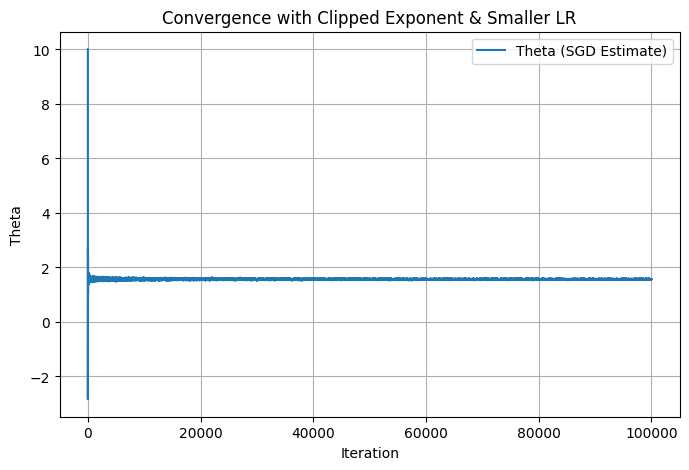

In [110]:
import numpy as np
import matplotlib.pyplot as plt
#define the gradient
def payoff(x):
    S = S0 * np.exp((r - 0.5*vol**2)*T + vol*np.sqrt(T)*x)
    return np.maximum(S - K, 0)
def grad(theta, Z):
    return (np.exp(theta**2/2-Z*theta)*payoff(Z)**2*(theta-Z)).mean()

# SGD parameters
theta_init = 0.01
gamma0 = 0.1       
alpha = 0.5         
N = 100000
batch_size = 100
clip_value = 100.0

theta = theta_init
theta_values = []

for n in range(1, N + 1):
    gamma_n = gamma0 / (n ** alpha)
    
    # Mini-batch
    z_batch = np.random.standard_normal(batch_size)
    
    # Gradient
    g = grad(theta, z_batch)
    
    # Clip gradient
    g = np.clip(g, -clip_value, clip_value)
    # Update
    theta -= gamma_n * g
    
    theta_values.append(theta)

print("Final theta from SGD:", theta)

# Plot
plt.figure(figsize=(8,5))
plt.plot(theta_values, label="Theta (SGD Estimate)")
plt.xlabel("Iteration")
plt.ylabel("Theta")
plt.title("Convergence with Clipped Exponent & Smaller LR")
plt.grid(True)
plt.legend()
plt.show()


From the plot we see that we quickly reach a relatively stable minimizing theta at around 1.57.

Next we implement the same algorithm but consider the payoff of a put option:
$$\varphi(Z) = \max(K-S_T, 0)$$

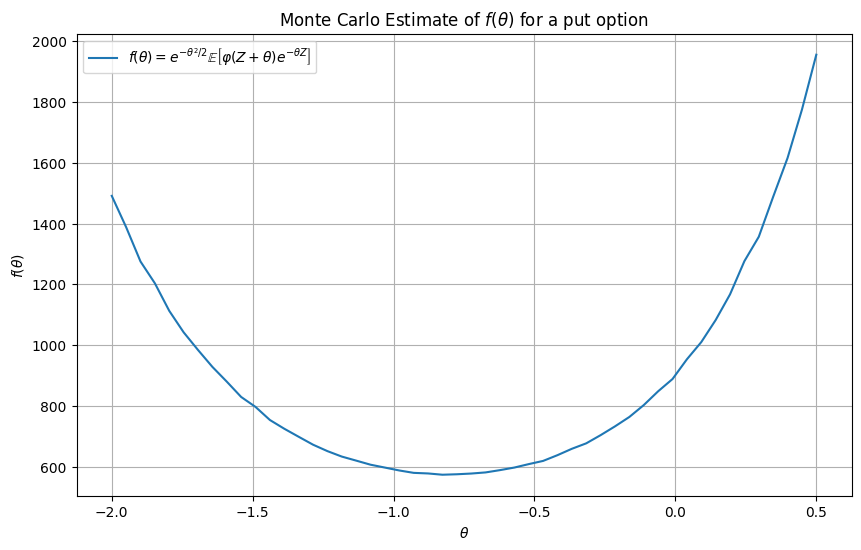

In [114]:
#setting parameters
S0 = 100.0  
K = 120   
T = 1.0      
r = 0.05     
vol = 0.3    

def payoff(x):
    S = S0 * np.exp((r - 0.5*vol**2)*T + vol*np.sqrt(T)*x)
    return np.maximum(K - S, 0)

def f_theta(theta, n_samples=100000):
    Z = np.random.standard_normal(n_samples)
    payoff_val = payoff(Z+theta)
    exponent = -2 * theta * Z
    weight = np.exp(exponent)
    f_val = weight * (payoff_val**2)
    return np.mean(f_val) * np.exp(-((theta)**2))


theta_values = np.linspace(-2,0.5, 50)  # adjust the range if needed
f_values = np.array([f_theta(theta) for theta in theta_values])

plt.figure(figsize=(10, 6))
plt.plot(theta_values, f_values, label=r"$f(\theta)=e^{-\theta^2 / 2}\mathbb{E} \left[ \varphi(Z + \theta)e^{-\theta Z} \right]$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$f(\theta)$")
plt.title("Monte Carlo Estimate of $f(\\theta)$ for a put option")
plt.legend()
plt.grid(True)
plt.show()

The plot indicates that $\theta^*\in(-1,-0.5)$. To locate this we do as before and implement a SGD algorithm.

Final theta from SGD: -0.795626427350555


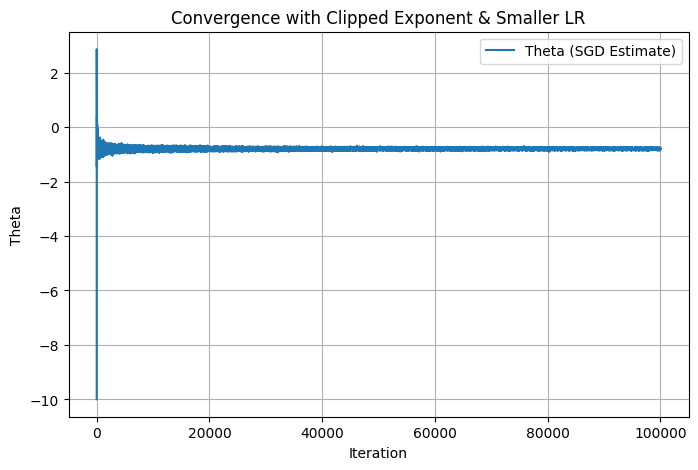

In [119]:
import numpy as np
import matplotlib.pyplot as plt
#define the gradient
def payoff(x):
    S = S0 * np.exp((r - 0.5*vol**2)*T + vol*np.sqrt(T)*x)
    return np.maximum(K - S, 0)
def grad(theta, Z):
    return (np.exp(theta**2/2-Z*theta)*payoff(Z)**2*(theta-Z)).mean()

# SGD parameters
theta_init = 0.01
gamma0 = 0.1       
alpha = 0.5         
N = 100000
batch_size = 100
clip_value = 100.0

theta = theta_init
theta_values = []

window_size = 1000
for n in range(1, N + 1):
    gamma_n = gamma0 / (n ** alpha)
    
    # Mini-batch
    z_batch = np.random.standard_normal(batch_size)
    
    # Gradient
    g = grad(theta, z_batch)
    
    # Clip gradient
    g = np.clip(g, -clip_value, clip_value)
    # Update
    theta -= gamma_n * g
    
    theta_values.append(theta)
    
print("Final theta from SGD:", theta)

# Plot
plt.figure(figsize=(8,5))
plt.plot(theta_values, label="Theta (SGD Estimate)")
plt.xlabel("Iteration")
plt.ylabel("Theta")
plt.title("Convergence with Clipped Exponent & Smaller LR")
plt.grid(True)
plt.legend()
plt.show()

We observe a rather stable convergence towards -0.78.

We have hereby estimated the optimal $\theta$  minimizes variance of the payoff in the framework of parametric importance sampling for a deep out of the money call and put options. Our convegence plot show us that the algorithms descend to the minimial theta with stability.
